This is an supervised classification example taken from the KDD 2009 cup.  A copy of the data and details can be found here: [https://github.com/WinVector/PDSwR2/tree/master/KDD2009](https://github.com/WinVector/PDSwR2/tree/master/KDD2009).  The problem was to predict account cancellation ("churn") from very messy data (column names not given, numeric and categorical variables, many missing values, some categorical variables with a large number of possible levels).  In this example we show how to quickly use `vtreat` to prepare the data for modeling.  `vtreat` takes in `Pandas` `DataFrame`s and returns both a treatment plan and a clean `Pandas` `DataFrame` ready for modeling.

The results shown here are for only one data set, one modeling method, and one family of hyper-parameters, and mild imbalance. However, the results are typical of what we see in production: once one builds probability models and looks closely, resampling is less attractive and may be a ritual instead of a useful tool.

Load our packages/modules.

In [1]:
import pandas
import xgboost
import vtreat
import vtreat.cross_plan
import numpy.random
import wvpy.util
import scipy.sparse
import sklearn.metrics
import matplotlib
# https://imbalanced-learn.org/stable/over_sampling.html
import imblearn.over_sampling

Read in explanatory variables.

In [2]:
# data from https://github.com/WinVector/PDSwR2/tree/master/KDD2009
dir = "../../PracticalDataScienceWithR2nd/PDSwR2/KDD2009/"
d = pandas.read_csv(dir + 'orange_small_train.data.gz', sep='\t', header=0)
vars = [c for c in d.columns]
d.shape

(50000, 230)

Read in dependent variable we are trying to predict.

In [3]:
churn = pandas.read_csv(dir + 'orange_small_train_churn.labels.txt', header=None)
churn.columns = ["churn"]
churn.shape

(50000, 1)

In [4]:
churn["churn"].value_counts()

-1    46328
 1     3672
Name: churn, dtype: int64

Arrange test/train split.

In [5]:
numpy.random.seed(2020)
n = d.shape[0]
# https://github.com/WinVector/pyvtreat/blob/master/Examples/CustomizedCrossPlan/CustomizedCrossPlan.md
split1 = vtreat.cross_plan.KWayCrossPlanYStratified().split_plan(n_rows=n, k_folds=10, y=churn.iloc[:, 0])
train_idx = set(split1[0]['train'])
is_train = [i in train_idx for i in range(n)]
is_test = numpy.logical_not(is_train)

(The reported performance runs of this example were sensitive to the prevalance of the churn variable in the test set, we are cutting down on this source of evaluation variarance by using the stratified split.)

In [6]:
d_train = d.loc[is_train, :].copy()
d_train.reset_index(inplace=True, drop=True)
churn_train = numpy.asarray(churn.loc[is_train, :]["churn"]==1)
d_test = d.loc[is_test, :].copy()
d_test.reset_index(inplace=True, drop=True)
churn_test = numpy.asarray(churn.loc[is_test, :]["churn"]==1)

Take a look at the dependent variables.  They are a mess, many missing values.  Categorical variables that can not be directly used without some re-encoding.

In [7]:
d_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN
4,NaN,NaN,NaN,NaN,NaN,658.0,7.0,NaN,NaN,NaN,...,zCkv,QqVuch3,LM8l689qOp,NaN,NaN,Qcbd,02N6s8f,Zy3gnGM,am7c,NaN


In [8]:
d_train.shape

(45000, 230)

Let's quickly prepare a data frame with none of these issues.

We start by building our treatment plan, this has the `sklearn.pipeline.Pipeline` interfaces.

In [9]:
plan = vtreat.BinomialOutcomeTreatment(
    outcome_target=True,
    params=vtreat.vtreat_parameters({
        'filter_to_recommended': True,
        'sparse_indicators': False
    }))

Use `.fit_transform()` to get a special copy of the treated training data that has cross-validated mitigations againsst nested model bias. We call this a "cross frame." `.fit_transform()` is deliberately a different `DataFrame` than what would be returned by `.fit().transform()` (the `.fit().transform()` would damage the modeling effort due nested model bias, the `.fit_transform()` "cross frame" uses cross-validation techniques similar to "stacking" to mitigate these issues).

In [10]:
cross_frame = plan.fit_transform(d_train, churn_train)

Take a look at the new data.  This frame is guaranteed to be all numeric with no missing values, with the rows in the same order as the training data.

In [11]:
cross_frame.head()

,Var84_is_bad,Var49_is_bad,Var7_is_bad,Var38_is_bad,Var44_is_bad,Var201_is_bad,Var184_is_bad,Var183_is_bad,Var75_is_bad,Var150_is_bad,...,Var227_lev_nIGXDli,Var197_prevalence_code,Var217_prevalence_code,Var200_logit_code,Var200_prevalence_code,Var200_lev__NA_,Var207_prevalence_code,Var207_lev_me75fM6ugJ,Var207_lev_7M47J5GA0pTYIFxg5uy,Var207_lev_DHn_WUyBhW_whjA88g9bvA64_
0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.089244,0.000067,-3.839145e-03,0.509111,1.0,0.701267,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.008489,0.013956,-4.197609e-03,0.509111,1.0,0.701267,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.002311,0.001867,2.220446e-16,0.000044,0.0,0.069933,0.0,0.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.003867,0.002333,-3.435875e+00,0.000089,0.0,0.701267,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.089244,0.001556,-1.069223e-02,0.509111,1.0,0.069933,0.0,0.0,1.0


In [12]:
cross_frame.shape

(45000, 234)

Pick a recommended subset of the new derived variables.

In [13]:
plan.score_frame_.head()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,R2,significance,vcount,default_threshold,recommended
0,Var84_is_bad,Var84,missing_indicator,False,True,0.016325,0.000576,2.253129e-04,193.0,0.001036,True
1,Var151_is_bad,Var151,missing_indicator,False,True,0.014288,0.000446,1.169199e-03,193.0,0.001036,False
2,Var49_is_bad,Var49,missing_indicator,False,True,0.016358,0.000579,2.184160e-04,193.0,0.001036,True
3,Var7_is_bad,Var7,missing_indicator,False,True,-0.026297,0.001427,6.437306e-09,193.0,0.001036,True
4,Var190_is_bad,Var190,missing_indicator,False,True,0.006103,0.000078,1.756498e-01,193.0,0.001036,False


In [14]:
model_vars = numpy.asarray(plan.score_frame_["variable"][plan.score_frame_["recommended"]])
model_vars.sort()
len(model_vars)

234

Fit the model

In [15]:
def fit_model(*, explanatory_variables, dependent_variable, tree_depth=3):
    x_parameters = {
        "max_depth":tree_depth, 
        "objective":'binary:logistic',
        "eval_metric": 'logloss'}
    # cross validate for good number of trees on simulated out of sample data
    cross_dmatrix = xgboost.DMatrix(
        data=explanatory_variables, 
        label=dependent_variable)
    cv = xgboost.cv(x_parameters, cross_dmatrix, num_boost_round=100, verbose_eval=False)
    best = cv.loc[cv["test-logloss-mean"]<= min(cv["test-logloss-mean"]), :]
    ntree = best.index.values[0] + 1
    # refit with this number of trees
    model = xgboost.XGBClassifier(
        n_estimators=ntree, 
        max_depth=tree_depth, 
        objective='binary:logistic',
        eval_metric = 'logloss')
    model.fit(explanatory_variables, dependent_variable)
    return(model)

In [16]:
model = fit_model(
    explanatory_variables=cross_frame.loc[:, model_vars],
    dependent_variable=churn_train
)

/Users/johnmount/opt/anaconda3/envs/ai_academy_3_9/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [17]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=39, n_jobs=6,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

Plot the quality of the model on training data (a biased measure of performance).

<Figure size 432x288 with 0 Axes>

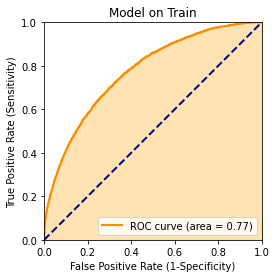

0.7744362249604722

In [18]:
pf_train = pandas.DataFrame({"churn":churn_train})
pf_train["pred"] = model.predict_proba(cross_frame.loc[:, model_vars])[:, 1]
wvpy.util.plot_roc(pf_train["pred"], pf_train["churn"], title="Model on Train")

Apply the data transform to our held-out data.

In [19]:
test_processed = plan.transform(d_test)

Plot the quality of the model score on the held-out data.  This AUC is not great, but in the ballpark of the original contest winners.

<Figure size 432x288 with 0 Axes>

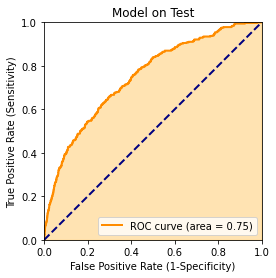

0.7478334705610067

In [20]:
pf = pandas.DataFrame({"churn": churn_test})
pf["pred"] = model.predict_proba(test_processed.loc[:, model_vars])[:, 1]
wvpy.util.plot_roc(
    prediction=pf["pred"], 
    istrue=pf["churn"], 
    title="Model on Test")

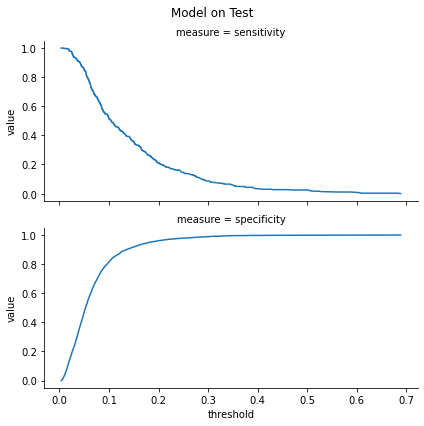

In [21]:
wvpy.util.threshold_plot(
    pf,
    pred_var="pred", 
    truth_var="churn", 
    plotvars=("sensitivity", "specificity"),
    title="Model on Test")

Notice we dealt with many problem columns at once, and in a statistically sound manner. More on the `vtreat` package for Python can be found here: [https://github.com/WinVector/pyvtreat](https://github.com/WinVector/pyvtreat).  Details on the `R` version can be found here: [https://github.com/WinVector/vtreat](https://github.com/WinVector/vtreat).

We can compare this to the [R solution (link)](https://github.com/WinVector/PDSwR2/blob/master/KDD2009/KDD2009vtreat.md).

Let's make the deliberate mistake of calling `.predict()` insteadl of `.predictd_proba()`.

In [22]:
pf["hard_decision_rule"] = model.predict(test_processed.loc[:, model_vars])

In [23]:
pandas.crosstab(pf.churn, pf.hard_decision_rule)

hard_decision_rule,False,True
churn,,
False,4625,6
True,360,9


This *superficially* looks very bad, few examples are classified as positive. Our point is: if we don't like how many positives were return simply call `.predict_proba()` and pick threshold more to your liking later.

This model is good as, the distribution of score conditioned on outcomes differ. We can see that in the following graph.

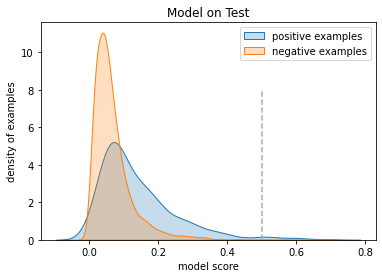

In [24]:
wvpy.util.dual_density_plot(
    probs=pf["pred"], 
    istrue=pf["churn"], 
    title="Model on Test",
    show=False
)
matplotlib.pyplot.plot([0.5, 0.5], [0, 8], 
                       color='DarkGrey', linestyle='--')

It is just the case that the model did not place many scores above 0.5. 0.5 being the hard-coded decision treshold
if you call `.predict()`. However at another threshold, say 0.2 one sees a non-negigble fraction of the positives and
a lesser fraction of the negatives. That would in fact be a useful threshold.

Our strong advice: popluate the model score in your system, and leave the threshold and even the possibility of
varying the threshold to the business stakeholders!

In [25]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
        y_true=pf["churn"], 
        y_pred=pf["hard_decision_rule"]).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

decision_rule_performance = pandas.DataFrame({
    'tpr': [sensitivity],
    'fpr': [1 - specificity],
    'label': ['Naive']
})

decision_rule_performance

,tpr,fpr,label
0,0.02439,0.001296,Naive


The summary of how a probability score behaves with respect to every possible thershold is usually summarized in an "ROC plot".
Though, we advise using the unwound thresholds plot for clarity.

Now let's look at rebalanced solutions attempt to work around this mistake.

In [26]:
def evaluate_resampling_method(*, method, name=None):
    if name is None:
        name = str(method)
    # resample the prepared training data
    x_resampled, y_resampled = method.fit_resample(
        cross_frame.loc[:, model_vars],
        churn_train)
    # build a new model
    model_resampled = fit_model(
        explanatory_variables=x_resampled,
        dependent_variable=y_resampled
    )
    # evaluate the model on train
    pf_resampled_test = pandas.DataFrame({"churn": churn_test})
    pf_resampled_test["pred"] = model_resampled.predict_proba(test_processed.loc[:, model_vars])[:, 1]
    pf_resampled_test["hard_decision_rule"] = model_resampled.predict(test_processed.loc[:, model_vars])
    # summarize the performance
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
        y_true=pf_resampled_test["churn"], 
        y_pred=pf_resampled_test["hard_decision_rule"]).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    perf_frame = pandas.DataFrame({
        'tpr': [sensitivity],
        'fpr': [1 - specificity],
        'label': [name]
    })
    return({
        'pf': pf_resampled_test, 
        'specificity': specificity, 
        'sensitivity': sensitivity,
        'perf_frame': perf_frame})

In [27]:
%%capture
# https://imbalanced-learn.org/stable/introduction.html
method_evals = [
    evaluate_resampling_method(
        method=imblearn.over_sampling.RandomOverSampler(),
        name='over'),
    evaluate_resampling_method(
        method=imblearn.over_sampling.RandomOverSampler(sampling_strategy=1/3),
        name='over(1/3)'),
    evaluate_resampling_method(
        method=imblearn.over_sampling.RandomOverSampler(sampling_strategy=2/3),
        name='over(2/3)'),
    evaluate_resampling_method(
        method=imblearn.under_sampling.RandomUnderSampler(),
        name='under'),
    evaluate_resampling_method(
        method=imblearn.over_sampling.SMOTE()),
    evaluate_resampling_method(
        method=imblearn.over_sampling.ADASYN()),
    evaluate_resampling_method(
        method=imblearn.combine.SMOTEENN())
]

In [28]:
perf_frame = pandas.concat(
    [decision_rule_performance] +
    [ei['perf_frame'] for ei in method_evals]
)
perf_frame

,tpr,fpr,label
0,0.024390,0.001296,Naive
0,0.574526,0.241417,over
0,0.241192,0.050097,over(1/3)
0,0.422764,0.127402,over(2/3)
0,0.677507,0.334917,under
0,0.021680,0.000864,SMOTE()
0,0.021680,0.001080,ADASYN()
0,0.203252,0.048370,SMOTEENN()


<Figure size 432x288 with 0 Axes>

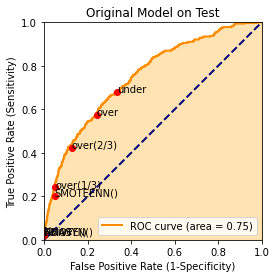

0.7478334705610067

In [29]:
wvpy.util.plot_roc(
    prediction=pf["pred"], 
    istrue=pf["churn"], 
    title="Original Model on Test",
    extra_points=perf_frame)

The re-sampling plans are, at best, just laborious ways to try and trace out the efficient frontier of the ROC plot. Re-sampling's primary
contribuition in this sort of application is: it almost undoes the mistake of calling `.predict()` (instisting on using decision rules for decision
problems) instead of taking the trouble to call `.predict_proba()`. Our position is, take the simple step
of calling `.predict_proba()` and keeping the probabilities around and you don't need any of the resamping
machinery.

This study was inspired by by Dr. Nina Zumel's earlier observation that rebalancing just approximates the ROC curve: [*Does Balancing Classes Improve Classifier Performance?*](https://win-vector.com/2015/02/27/does-balancing-classes-improve-classifier-performance/).

Some follow up material includes:
 
   * [Against Accuracy](https://win-vector.com/2020/12/27/against-accuracy/) (why not to use accuarcy as a measure).
   * [Don’t Use Classification Rules for Classification Problems](https://win-vector.com/2020/08/07/dont-use-classification-rules-for-classification-problems/) (why to use scores and not hard decision rules for classification problems).
   * [The Shift and Balance Fallacies](https://win-vector.com/2020/10/15/the-shift-and-balance-fallacies/) (some notes on rebalancine logistic regression models).
   



## Appendix: Plotting the ROCs

In this appendix we plot the ROCs of the additional re-balanced models. This is to demonstrate, that in
addition to not generarting any new regions of performance for decision rules, they also are not 
themselves new regions of performance as probabilty models.

<Figure size 432x288 with 0 Axes>

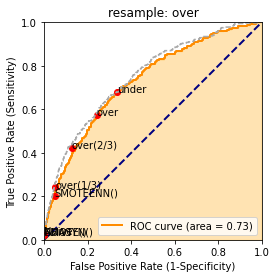

<Figure size 432x288 with 0 Axes>

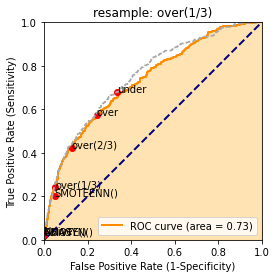

<Figure size 432x288 with 0 Axes>

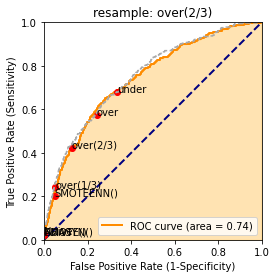

<Figure size 432x288 with 0 Axes>

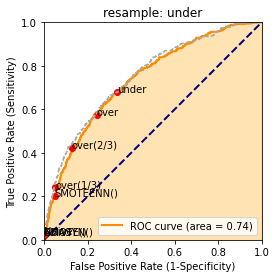

<Figure size 432x288 with 0 Axes>

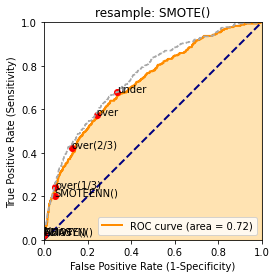

<Figure size 432x288 with 0 Axes>

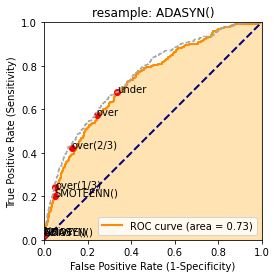

<Figure size 432x288 with 0 Axes>

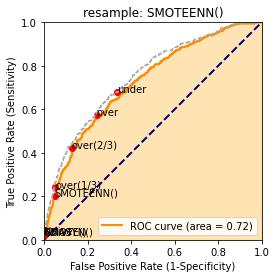

In [30]:
# get ROC curve for base probability model
fpr, tpr, _ = sklearn.metrics.roc_curve(
    y_true=pf["churn"], 
    y_score=pf["pred"])

# run through all resampled model evals
for i in range(len(method_evals)):
    me = method_evals[i]
    # plot ROC curve for resampled model
    wvpy.util.plot_roc(
        prediction=me['pf']["pred"], 
        istrue=me['pf']["churn"], 
        title="resample: " + me['perf_frame'].label[0],
        extra_points=perf_frame,
        show=False)
    # overlay ROC curve for base probability model
    matplotlib.pyplot.plot(
        fpr, tpr, linestyle="--", color='DarkGrey')

Notice in all cases the new organge ROC curve is pretty much under (dominated by) the grey ROC curve from the original model prior to re-balancing! This is illustrating the rebalancing achieved nothing (in this case, for these rebalances, these hyper parameters, for this specific problem, and machine learning algorithm).